In [64]:
import sdeint
import numpy as np
import csv
#import random as rand
import matplotlib.pyplot as plt
#from itertools import accumulate
from scipy.optimize import curve_fit
from synthetic_env import synthetic_env
from naive_agents import DoNothing, FixedPhi
#from scipy.stats import norm

## First run Numerics Outside of Environment

In [65]:
def expected_prop_2d(r,PHI,D,r_d,scaling=1.0):
    return scaling*np.power((r_d/r),(2*(PHI-D)/D))/r

def f(u, t):
    #print(u)
    return np.array([
        u[2]*u[0] + u[3]*u[1] - PHI * u[0],
        u[4]*u[0] + u[5]*u[1] - PHI * u[1],
        -u[2],
        -u[3],
        -u[4],
        -u[5]
    ])

def g(u, t):
    return np.array([
        [np.sqrt(kappa), 0, 0, 0, 0],
        [0, np.sqrt(kappa), 0, 0, 0],
        [0, 0, np.sqrt(D), 0, 0],
        [0, 0, 0, np.sqrt(D), np.sqrt(2) * np.sqrt(D)],
        [0, 0, 0, np.sqrt(D), -np.sqrt(2) * np.sqrt(D)],
        [0, 0, -np.sqrt(D), 0, 0]
    ])

def penalty(sep,phi,beta,delta_t):
    return (phi**2+beta)*sep**2*delta_t

In [66]:
# Choose Params
dim=2
kappa = 0.001
D = 0.1
BETA = 0.1
D_tilde = D*(dim+1)*(dim-1)
PHI = (D_tilde + np.sqrt(4*BETA+D_tilde))/2
r_d = np.sqrt(kappa/D)
t_end = 10.0

delta_t = 0.1
NU = 0.99
intial_sep=0.2*np.pi

#Params that are close to ABC flow params

#PHI = 0.7  
#kappa = 0.02*np.pi
#D = 0.25
#r_d = np.sqrt(kappa/D)
print(PHI)

0.5683300132670378


In [67]:
(D_tilde + np.sqrt(4*BETA+D_tilde**2))/2

0.5

In [82]:
# Run the SDEs
dictionary = {}
num_eps =25000
noise_initial = np.array([0,0,0,0,0,0])
noise_initial[:2] = np.random.rand(2) - 0.5
noise_initial[:2] = noise_initial[:2]/np.linalg.norm(noise_initial[:2])*intial_sep
for i in range(num_eps):
    #update inital loc
    noise_initial[:2] = np.random.rand(2) - 0.5
    noise_initial[:2] = noise_initial[:2]/np.linalg.norm(noise_initial[:2])*intial_sep
    
    u0 = noise_initial


    tspan = np.arange(0.0, t_end,delta_t)  # 100 time units

    result = sdeint.itoint(f, g, u0, tspan)
    
    # storing last value for the random start of the next value in the uhlenbreck processes
    noise_initial = result[-1]

    separations = np.sum(result[:, :2]**2, axis=1)
    separations = np.sqrt(separations)


    N = len(separations)
    S_n = 0.0
    returns = np.zeros(N)
    discount = np.exp(-NU*delta_t)
    for i in range(1,N+1):
        S_n = S_n*discount + penalty(separations[N-i],PHI,BETA,delta_t)
        returns[N-i] = S_n
        
    
    delta_r = 0.002
    for i in range(N):
        key = (i, int(separations[i]/delta_r))
        if key in dictionary:
            # increase sum and count
            dictionary[key] = dictionary[key][0] + returns[i], dictionary[key][1] + 1
        else:
            dictionary[key] = [returns[i], 1]
    

/tmp/ipykernel_6187/3392160634.py:6: RuntimeWarning: invalid value encountered in divide
  noise_initial[:2] = noise_initial[:2]/np.linalg.norm(noise_initial[:2])*intial_sep
/tmp/ipykernel_6187/3392160634.py:6: RuntimeWarning: invalid value encountered in cast
  noise_initial[:2] = noise_initial[:2]/np.linalg.norm(noise_initial[:2])*intial_sep
/tmp/ipykernel_6187/3392160634.py:10: RuntimeWarning: invalid value encountered in divide
  noise_initial[:2] = noise_initial[:2]/np.linalg.norm(noise_initial[:2])*intial_sep
/tmp/ipykernel_6187/3392160634.py:10: RuntimeWarning: invalid value encountered in cast
  noise_initial[:2] = noise_initial[:2]/np.linalg.norm(noise_initial[:2])*intial_sep


In [83]:
with open(f'csv/non_sationary_eps:{num_eps}_dt:{delta_t}_dr:{delta_r}_end:{t_end}.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=list(dictionary.keys()))
    writer.writeheader()
    writer.writerow(dictionary)

In [84]:
# Specfic to 2 dimensions
def baseline(time_remaining,separation):
    dims=2
    # a useful intermediate value used in the baseline calculations
    d_tilde = 4*D
    block = NU + 2*PHI - d_tilde
    
    def A():
        num = (BETA + PHI**2)*(1-np.exp(-time_remaining*block))
        denom = block
        return num/denom
    
    def B():
        first_term = dims * kappa * (BETA + PHI**2) / (NU*(2*PHI-d_tilde))
        second_term = 1 - np.exp(-NU*time_remaining) - NU * (1-np.exp(-time_remaining*block))/block
        return first_term*second_term
        
    
    return A()*separation**2 + B()

In [90]:
t_end = max(tspan)
sampled = np.zeros([350,len(tspan)])
evaluated = np.zeros([350,len(tspan)])
count_threshhold = 100
for key, value in dictionary.items():
    if value[1] > count_threshhold:
        time_remaining = t_end - key[0]*delta_t
        sep = key[1]*delta_r
        sampled[key[1]][key[0]] = value[0]/value[1]
        evaluated[key[1]][key[0]] = baseline(time_remaining,sep)

In [91]:
sampled.max()

0.11464220115391868

In [92]:
"""
from pylab import *
from matplotlib.colors import LinearSegmentedColormap

class nlcmap(LinearSegmentedColormap):
    #A nonlinear colormap
    
    name = 'nlcmap'
    
    def __init__(self, cmap, levels):
        self.cmap = cmap
        # @MRR: Need to add N for backend
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels / self.levels.max()
        self._y = linspace(0.0, 1.0, len(self.levels))
    
    #@MRR Need to add **kw for 'bytes'
    def __call__(self, xi, alpha=1.0, **kw):
        #docstring for fname
        # @MRR: Appears broken? 
        # It appears something's wrong with the
        # dimensionality of a calculation intermediate
        #yi = stineman_interp(xi, self._x, self._y)
        yi = interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)
    
    
y, x = mgrid[0.0:3.0:100j, 0.0:5.0:100j]
H = 50.0 * exp( -(x**2 + y**2) / 4.0 )
levels = [0, 1, 2, 3, 6, 9, 20, 50]

cmap_lin = cm.jet
cmap_nonlin = nlcmap(cmap_lin, levels)

subplot(2,1,1)
contourf(x, y, H, levels, cmap=cmap_nonlin)
colorbar()
subplot(2,1,2)
#contourf(x, y, H, levels, cmap=cmap_lin)
colorbar()

savefig('nlcmap_example.png')
"""

"\nfrom pylab import *\nfrom matplotlib.colors import LinearSegmentedColormap\n\nclass nlcmap(LinearSegmentedColormap):\n    #A nonlinear colormap\n    \n    name = 'nlcmap'\n    \n    def __init__(self, cmap, levels):\n        self.cmap = cmap\n        # @MRR: Need to add N for backend\n        self.N = cmap.N\n        self.monochrome = self.cmap.monochrome\n        self.levels = np.asarray(levels, dtype='float64')\n        self._x = self.levels / self.levels.max()\n        self._y = linspace(0.0, 1.0, len(self.levels))\n    \n    #@MRR Need to add **kw for 'bytes'\n    def __call__(self, xi, alpha=1.0, **kw):\n        #docstring for fname\n        # @MRR: Appears broken? \n        # It appears something's wrong with the\n        # dimensionality of a calculation intermediate\n        #yi = stineman_interp(xi, self._x, self._y)\n        yi = interp(xi, self._x, self._y)\n        return self.cmap(yi, alpha)\n    \n    \ny, x = mgrid[0.0:3.0:100j, 0.0:5.0:100j]\nH = 50.0 * exp( -(x**2 +

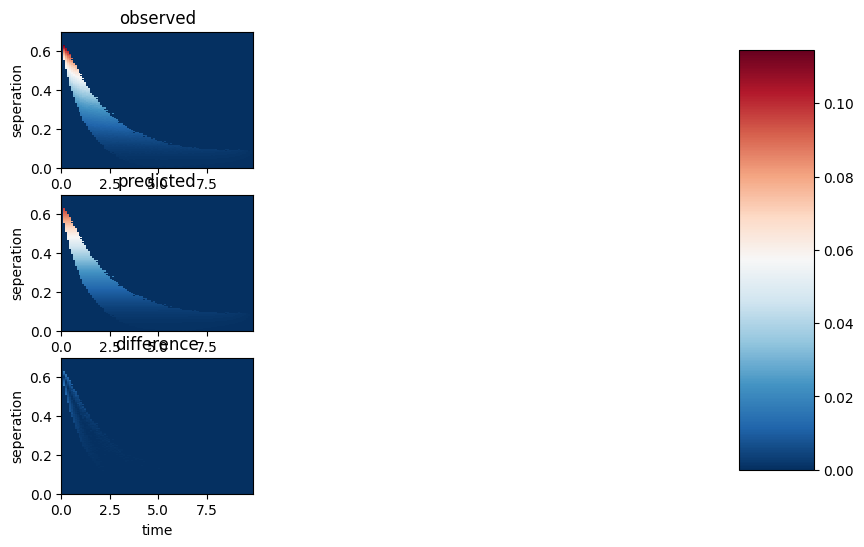

In [98]:
cmap="RdBu_r"
#cmap = matplotlib.cm.get_cmap('RdBu_r')


#levels = np.array([0, 1, 2, 3, 6, 9, 20, 50], dtype='float64')/100

#cmap_lin = cm.jet
#cmap = nlcmap(cmap_lin, levels)



fig, ax = plt.subplots(3, 1)
minmin = 0.
maxmax = max(sampled.max(),evaluated.max())
scale = ax[0].imshow(np.flip(sampled,axis=0),vmin=minmin, vmax=maxmax, interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10,cmap=cmap)
scale2 = ax[1].imshow(np.flip(evaluated,axis=0), vmin=minmin, vmax=maxmax,interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10,cmap=cmap)
scale3 = ax[2].imshow(np.abs(np.flip((evaluated-sampled),axis=0)), vmin=minmin, vmax=maxmax,interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10,cmap=cmap)
fig.set_size_inches(15,6)
#fig.colorbar(scale, ax=ax[0])
#fig.colorbar(scale2, ax=ax[1])
#fig.colorbar(scale3, ax=ax[2])

ax[0].set_xlabel('')
ax[0].set_ylabel('seperation')
ax[0].set_title("observed")
#ax[0].set_ylim(0,0.1)

ax[1].set_xlabel('')
ax[1].set_ylabel('seperation')
ax[1].set_title("predicted")
#ax[1].set_ylim(0,0.1)

ax[2].set_xlabel('time')
ax[2].set_ylabel('seperation')
ax[2].set_title("difference")
#ax[2].set_ylim(0,0.1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(scale, cax=cbar_ax)

In [9]:
plt.plot(sampled[:,200])
plt.plot(evaluated[:,200])
plt.xlabel("seperation")
plt.ylabel("return")
plt.legend(labels=["observed","predicted"])

IndexError: index 200 is out of bounds for axis 1 with size 100

In [ ]:
# start of random play ground
assert(1==0)

In [ ]:
sampled[:200].shape

In [ ]:
np.array([1,2,3]) / np.array([1,2,3])

In [ ]:
sampled-evaluated

In [ ]:
sampled[314][0]

In [ ]:
evaluated[314][0]

In [ ]:
image.shape

In [ ]:
A = np.random.random((5,5))
A[2,2]=0.
plt.imshow(A, interpolation='nearest')

In [ ]:
A

In [ ]:
N

In [ ]:
dictionary[(1,312)]

In [ ]:
import sys
sys.getsizeof(dictionary)


In [ ]:
import csv

In [ ]:

with open(f'bins_{num_eps}.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=list(dictionary.keys()))
    writer.writeheader()
    writer.writerow(dictionary)

In [ ]:
list(dictionary.keys())

In [ ]:
dictionary.keys()

In [ ]:
N = len(separations)
S_n = 0.0
returns = np.zeros(N)
discount = np.exp(-NU*delta_t)
for i in range(1,N+1):
    S_n = S_n*discount + penalty(separations[N-i],PHI,BETA,delta_t)
    returns[N-i] = S_n
    #S_n = np.append(S_n, S_n[i-1]*discount + penalty(separations[N-i],PHI,BETA,delta_t))

In [ ]:
len(returns)

In [ ]:
len(tspan)

In [ ]:
len(separations)

In [ ]:
plt.plot(np.arange(N) * delta_t,returns)

In [ ]:
np.arange(N) * delta_t

In [ ]:
N = len(separations)-1
S_n = np.array([(PHI**2+BETA)*np.exp(0)*separations[-1]**2*delta_t])
for r in reversed(separations[:-1]):
    S_n = S_n.append(S_n,(PHI**2+BETA)*np.exp(-nu*(N-index)*delta_t)*separations[index]**2*delta_t
    

In [ ]:
len(separations)

In [ ]:
len(tspan)

In [ ]:
tspan

In [ ]:
# Plot observed distribution don't plot early values before the distribution has settled into the stationary distribution
n,bins,_ = plt.hist(separations[1000:], bins=500, density=True, alpha=0.5)
x_points = np.arange(r_d,max(separations[1000:]),0.01)
plt.plot(x_points,expected_prop_2d(x_points,PHI,D,r_d))
plt.yscale("log")
plt.ylim(bottom=10**(-7),top=10**(2))

## Now run within the environment to check that results are similiar 

In [ ]:
# run environment with same parameters as above this is a good bit slower than just the bare bone numerics
fixed_agent = FixedPhi(PHI)
env = synthetic_env(r_d, D=D,kappa=kappa)
env.deltaT= 0.005
env.limit = 10000
observed_distances = []
while not env.isOver():
    action = fixed_agent.sample_action(env.getState())
    reward = env.step(action)
    observed_distances.append(env.dist())

In [ ]:
n,bins,_ = plt.hist(observed_distances, bins=500, density=True, alpha=0.5)
x_points = np.arange(r_d,max(observed_distances[1000:]),0.01)
plt.plot(x_points,expected_prop_2d(x_points,PHI,D,r_d))
plt.yscale("log")
plt.ylim(bottom=10**(-7),top=10**(2))